# CNN AE

In [1]:
# 这是训练CAE模型的程序

# cnn autoncoder model
import tensorflow as tf
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, AveragePooling1D,Reshape,UpSampling1D
from keras.models import Model, Sequential
from keras import initializers
from keras.layers import BatchNormalization

#CNN autoencoder
def CNN_encoder(input,dims):
  ## encoding part
  initializer = tf.keras.initializers.HeNormal()
  # 四层卷积层，再加池化层压缩数据最后再flat展开，一维卷积
  # 参数分别为卷积核个数即输出维度，卷积核大小，激活函数,padding是当卷积核超出边界时的处理方式,same是补0,padding的其他参数还有valid，不补0
  layer = Conv1D(64, kernel_size=3, padding="same", activation="relu")(input)
  layer = BatchNormalization()(layer)
  layer = MaxPooling1D(pool_size=2)(layer)
  layer = Dropout(0.25)(layer)
  layer = Conv1D(128, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling1D(pool_size=2)(layer)
  layer = Dropout(0.25)(layer)
  layer = Conv1D(256, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling1D(pool_size=2)(layer)
  layer = Dropout(0.25)(layer)
  layer = Conv1D(512, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling1D(pool_size=2)(layer)
  layer = Dropout(0.25)(layer)
  
# 这一层的作用是将输入展平。不影响批量大小
  layer = Flatten()(layer)
  # 利用全连接层将已经经过压缩的数据再次压缩到指定维度
  encoded = Dense(dims, activation="relu")(layer)
  return encoded

# 解码函数，通过卷积层+上采样层，还原数据
def CNN_decoder(encoded):
  ## decoding part
  initializer = tf.keras.initializers.HeNormal()
  layer = Dense(250* 512, activation="relu", use_bias=False)(encoded)
  layer = Reshape((250, 512))(layer)
  layer = Conv1D(512, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = UpSampling1D(size=2)(layer)
  layer = Conv1D(256, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = UpSampling1D(size=2)(layer)
  layer = Conv1D(128, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = UpSampling1D()(layer)
  layer = Conv1D(64, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = UpSampling1D()(layer)
  decoded = Conv1D(1, kernel_size=3, padding="same", activation="sigmoid")(layer)

  return decoded
def CAE_model(Train_X,dims):
  CNNinput_layer = Input(shape=(Train_X.shape[1],1))
  # 编码后的数据
  cnn_x = CNN_encoder(CNNinput_layer,dims)
  # 解码后的数据
  cnn_x_hat = CNN_decoder(cnn_x)
  # 把编码和解码拼接成一个模型
  CNNmodel = Model(CNNinput_layer, cnn_x_hat)
  CNN_enconder = Model(CNNinput_layer, cnn_x, name="encoder")
  return CNNmodel,CNN_enconder

def CAE_hiddenrepresentation(data,method_enconder):
        """Transform the vector.
        From original dimensions to latent dimensions.
        Parameters
        ----------
        data : array-like  (n_samples, n_features)
            The input data to use in transform process.
        Returns
        -------
        _ : array-like  (n_samples, value_encoding_dim)
            The data transformed to latent dimensions format.
        """
        return method_enconder.predict(data)
      
# 截取编码层
def CNNextractrep(model):
  hidden_representation = Sequential()
  for i in range(19):  # Adjust this number based on the total number of layers in your model
    hidden_representation.add(model.layers[i])
  return hidden_representation

# loading and preprocessing

In [2]:
%load_ext autotime
#限制显存
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])

time: 46.6 ms (started: 2024-05-01 19:48:59 +08:00)


In [3]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn import preprocessing 
from sklearn import svm
from tensorflow import keras
from sklearn.metrics import plot_confusion_matrix
from keras.callbacks import History
from sklearn.metrics import confusion_matrix
import re
from imblearn.under_sampling import ClusterCentroids
sns.set(style="whitegrid")
np.random.seed(203)

epoch_num=500
# drive.mount('/content/drive')

time: 886 ms (started: 2024-05-01 19:48:59 +08:00)


In [4]:
# uncomment this part if you have saved the clustered data before
# 读取已有数据 
new_Train_total=pd.read_csv('/home/Q/Diploma_thesis/CAE_ADD-main/data/new_Train_total_CAE_1k.csv')
new_Test_total=pd.read_csv('/home/Q/Diploma_thesis/CAE_ADD-main/data/new_Test_total_CAE_1k.csv')
new_Dev_total=pd.read_csv('/home/Q/Diploma_thesis/CAE_ADD-main/data/new_Dev_total_CAE_1k.csv')
# new_Test_total = new_Test_total.iloc[: , 1:]
# new_Train_total = new_Train_total.iloc[: , 1:]
# new_Dev_total = new_Dev_total.iloc[: , 1:]

print(new_Train_total.shape)
print(new_Test_total.shape)
print(new_Dev_total.shape)

(7798, 4001)
(3054, 4001)
(2298, 4001)
time: 10.3 s (started: 2024-05-01 19:49:00 +08:00)


In [5]:
new_Train_total.head(5)

,0,1,2,3,4,5,6,7,8,9,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,Class
0,0.001654,0.002027,0.002294,0.002431,0.002530,0.002599,0.002753,0.002871,0.002989,0.002535,...,-0.000130,-0.000080,0.000072,0.000346,0.000527,0.000616,0.000707,0.000791,0.000691,0.0
1,-0.000221,-0.000244,-0.000274,-0.000196,0.000033,-0.000159,-0.000158,0.000032,0.000037,-0.000096,...,0.000079,0.000415,0.000831,0.001120,0.000905,0.000626,0.000630,0.000653,0.000817,0.0
2,0.023386,0.085732,-0.049411,-0.016143,0.051555,-0.033860,-0.031203,-0.026818,-0.030780,0.075662,...,-0.034582,0.026309,-0.024201,0.007665,-0.015161,-0.004017,-0.045390,-0.032923,-0.031988,0.0
3,0.002669,0.002423,0.002891,0.001642,0.001689,0.001749,0.000291,0.001359,0.000874,0.001303,...,-0.000341,-0.000403,-0.000209,-0.000126,-0.000262,-0.000147,-0.000071,-0.000104,-0.000197,0.0
4,-0.021493,-0.020096,-0.019276,-0.017633,-0.016908,-0.015893,-0.015329,-0.014385,-0.011066,-0.007990,...,-0.005358,-0.007087,0.000884,0.018442,-0.007315,-0.003705,-0.007224,0.003930,0.018891,0.0


time: 25.3 ms (started: 2024-05-01 19:49:10 +08:00)


In [6]:
#数据标准化
#---------before training perform Max-Min scalling
Scaler=preprocessing.MinMaxScaler()  # 实例化一个MinMaxScaler对象，用于最大最小值缩放
x_train = new_Train_total.drop(["Class"], axis=1)  # 从new_Train_total中删除"Class"列，得到训练数据
y_train = new_Train_total["Class"].values  # 获取训练数据的标签

x_scaled_train = Scaler.fit_transform(x_train.values)  # 使用MinMaxScaler对训练数据进行最大最小值缩放
x_nondep_train, x_dep_train = x_scaled_train[y_train == 0], x_scaled_train[y_train == 1]  # 将缩放后的训练数据分为非依赖和依赖两部分
#---------before validating perform Max-Min scalling
x_val = new_Dev_total.drop(["Class"], axis=1)  # 从new_Dev_total中删除"Class"列，得到验证数据
y_val = new_Dev_total["Class"].values  # 获取验证数据的标签

x_scaled_val = Scaler.transform(x_val.values)  # 使用之前实例化的MinMaxScaler对验证数据进行最大最小值缩放
x_nondep_val, x_dep_val = x_scaled_val[y_val == 0], x_scaled_val[y_val == 1]  # 将缩放后的验证数据分为非依赖和依赖两部分
#---------before testing perform Max-Min scalling
x_test = new_Test_total.drop(["Class"], axis=1)  # 从new_Test_total中删除"Class"列，得到测试数据
y_test = new_Test_total["Class"].values  # 获取测试数据的标签

x_scaled_test = Scaler.transform(x_test.values)  # 使用之前实例化的MinMaxScaler对测试数据进行最大最小值缩放
x_nondep_test, x_dep_test = x_scaled_test[y_test== 0], x_scaled_test[y_test == 1]  # 将缩放后的测试数据分为非依赖和依赖两部分

time: 794 ms (started: 2024-05-01 19:49:10 +08:00)


In [7]:
x_scaled_train

array([[0.40506894, 0.45223323, 0.43526059, ..., 0.31707868, 0.30525233,
        0.34373122],
       [0.39591947, 0.44158834, 0.42451532, ..., 0.31688141, 0.30488914,
        0.34411305],
       [0.51111759, 0.84447216, 0.2189352 , ..., 0.1988987 , 0.21689803,
        0.24452222],
       ...,
       [0.38453945, 0.43910397, 0.41842828, ..., 0.31914973, 0.30680652,
        0.34601478],
       [0.37135886, 0.42517365, 0.4162766 , ..., 0.3129134 , 0.30125286,
        0.34654434],
       [0.39207814, 0.43865057, 0.42139682, ..., 0.31363374, 0.30269355,
        0.34096535]])

time: 3.9 ms (started: 2024-05-01 19:49:11 +08:00)


In [8]:
print(x_scaled_val.shape[1])
# 假设 audio_scaled 是你的归一化后的音频数据
nonzero_count = np.count_nonzero(x_scaled_test)

print("非零元素数量：", nonzero_count)
print("数组总元素数量：", x_scaled_test.size)

4000
非零元素数量： 12216000
数组总元素数量： 12216000
time: 299 ms (started: 2024-05-01 19:49:11 +08:00)


In [9]:
# # 释放显存，但整个进程都会挂掉
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

time: 413 µs (started: 2024-05-01 19:49:12 +08:00)


In [10]:
# 构建模型
from tensorflow.keras.optimizers import Adadelta
encodding_dim= 700
print(x_scaled_train.shape)
print(x_scaled_val.shape)

#初始化模型
epoch_num=500
Batchsize=64
#training
save_dir = '/home/Q/Diploma_thesis/CAE_ADD-main/models/'
# optimizer = Adadelta(rho=0.9, epsilon=1e-08, learning_rate=0.01)

CNN_autoencoder,CNN_latent=CAE_model(x_scaled_train,encodding_dim)
# adadelta的默认学习率是1.0,他会根据梯度自动调整学习率
CNN_autoencoder.compile(optimizer='adadelta', loss='mse')#specifying a loss, metrics, and an optimizer
# CNN_autoencoder.compile(optimizer, loss='mse')#specifying a loss, metrics, and an optimizer
print(CNN_autoencoder.output_shape)
print(CNN_autoencoder.input_shape)
#输出模型架构
print(CNN_autoencoder.summary())


(7798, 4000)
(2298, 4000)


2024-05-01 19:49:12.154234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 19:49:12.297790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6000 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:82:00.0, compute capability: 8.9


(None, 4000, 1)
(None, 4000, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 4000, 64)          256       
                                                                 
 batch_normalization (BatchN  (None, 4000, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2000, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2000, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           

# CAE training and testing

Epoch 1/500


2024-05-01 19:49:38.696833: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8900
2024-05-01 19:49:38.945443: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


122/122 [==============================] - ETA: 0s - loss: 0.0768
Epoch 1: val_loss improved from inf to 0.02525, saving model to /home/Q/Diploma_thesis/CAE_ADD-main/models/modeltotalCAE_norm_1k.h5
122/122 [==============================] - 51s 212ms/step - loss: 0.0768 - val_loss: 0.0253
Epoch 2/500
122/122 [==============================] - ETA: 0s - loss: 0.0686
Epoch 2: val_loss did not improve from 0.02525
122/122 [==============================] - 15s 125ms/step - loss: 0.0686 - val_loss: 0.0266
Epoch 3/500
122/122 [==============================] - ETA: 0s - loss: 0.0628
Epoch 3: val_loss did not improve from 0.02525
122/122 [==============================] - 16s 128ms/step - loss: 0.0628 - val_loss: 0.0284
Epoch 4/500
122/122 [==============================] - ETA: 0s - loss: 0.0579
Epoch 4: val_loss did not improve from 0.02525
122/122 [==============================] - 15s 126ms/step - loss: 0.0579 - val_loss: 0.0312
Epoch 5/500
122/122 [==============================] - ETA:

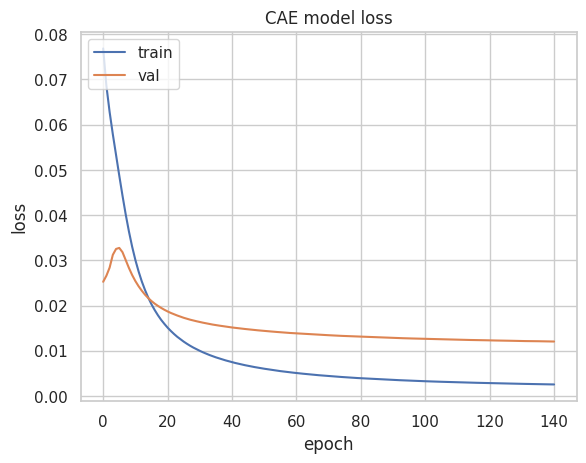

time: 50min 28s (started: 2024-05-01 19:49:12 +08:00)


In [11]:
# 构建模型
from tensorflow.keras.optimizers import Adadelta
encodding_dim= 700
print(x_scaled_train.shape)
print(x_scaled_val.shape)

#初始化模型
epoch_num=500
Batchsize=64
#training
save_dir = '/home/Q/Diploma_thesis/CAE_ADD-main/models/'
# optimizer = Adadelta(rho=0.9, epsilon=1e-08, learning_rate=0.01)

CNN_autoencoder,CNN_latent=CAE_model(x_scaled_train,encodding_dim)
# adadelta的默认学习率是1.0,他会根据梯度自动调整学习率
CNN_autoencoder.compile(optimizer='adadelta', loss='mse')#specifying a loss, metrics, and an optimizer
# CNN_autoencoder.compile(optimizer, loss='mse')#specifying a loss, metrics, and an optimizer


encodding_dim= 700
Batchsize = 64
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'modeltotalCAE_norm_1k.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.00005,
    patience=4,
    verbose=1, 
    mode='min',
    restore_best_weights=True)
callbacks_list = [early_stop, checkpoint]## This saves the best model
# FIT THE MODEL
#--------------------------CNN autoencoder-------------------------
history=CNN_autoencoder.fit(x_scaled_train, x_scaled_train, 
                batch_size = Batchsize, epochs = epoch_num, 
                shuffle=True, validation_data = (x_scaled_val, x_scaled_val),verbose=1,callbacks=callbacks_list);
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# val_loss是验证集的损失，loss是训练集的损失


In [12]:
# 计算MSE
import numpy as np
from sklearn.metrics import mean_squared_error

# 训练集和验证集的重构结果
train_reconstructed = CNN_autoencoder.predict(x_scaled_train)
val_reconstructed = CNN_autoencoder.predict(x_scaled_val)

# 计算训练集和验证集的MSE
train_mse = mean_squared_error(np.ravel(x_scaled_train), np.ravel(train_reconstructed))
val_mse = mean_squared_error(np.ravel(x_scaled_val), np.ravel(val_reconstructed))

print(f"Training MSE: {train_mse}")
print(f"Validation MSE: {val_mse}")

# Training MSE: 0.02250038380645789
# Validation MSE: 0.02517618863782179

# 没音量归一化前：
# Training MSE: 0.016431097988517482
# Validation MSE: 0.018738392874022684

72/72 [==============================] - 1s 16ms/step
Training MSE: 0.009622246439416353
Validation MSE: 0.01209463093968981
time: 7.28 s (started: 2024-05-01 20:55:34 +08:00)


In [11]:
# 也就是说，这段使用前面训练好的CAE模型，利用其中的编码·模型进行特征提取
# LOAD BEST MODEL to evaluate the performance of the model
CNN_autoencoder.load_weights("/home/Q/Diploma_thesis/CAE_ADD-main/models/modeltotalCAE_1k.h5")

#------find the new represenation of Train data
# LatentRepresenation就是提取自编码器的前十五行也就是编码器——降维提取特征
LatentRepresenation=CNNextractrep(CNN_autoencoder)
print(LatentRepresenation.summary())

x_nondep_training_data=x_nondep_train.copy()
x_dep_training_data=x_dep_train.copy()

x_nondep_training_data = np.expand_dims(x_nondep_training_data, axis=2)
x_dep_training_data = np.expand_dims(x_dep_training_data, axis=2)

# 利用编码器进行特征提取——测试集
Nondep_hid_rep_Train =LatentRepresenation.predict(x_nondep_training_data)
Dep_hid_rep_Train =LatentRepresenation.predict(x_dep_training_data)

rep_x_Train = np.append(Nondep_hid_rep_Train, Dep_hid_rep_Train, axis = 0)#total latent representation
y_n = np.zeros(Nondep_hid_rep_Train.shape[0])
y_d = np.ones(Dep_hid_rep_Train.shape[0])
rep_y_Train = np.append(y_n, y_d)#Total labels

x_nondep_validation_data=x_nondep_val.copy()
x_dep_validation_data=x_dep_val.copy()

# 利用编码器进行特征提取——验证集
x_nondep_validation_data= np.expand_dims(x_nondep_validation_data, axis=2)
x_dep_validation_data = np.expand_dims(x_dep_validation_data, axis=2)

Nondep_hid_rep_Valid =LatentRepresenation.predict(x_nondep_validation_data)
Dep_hid_rep_Valid =LatentRepresenation.predict(x_dep_validation_data)

rep_x_Valid = np.append(Nondep_hid_rep_Valid , Dep_hid_rep_Valid, axis = 0)#total latent representation
y_n_valid = np.zeros(Nondep_hid_rep_Valid .shape[0])
y_d_valid = np.ones(Dep_hid_rep_Valid.shape[0])
rep_y_Valid = np.append(y_n_valid, y_d_valid)#Total labels



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4000, 64)          256       
                                                                 
 batch_normalization (BatchN  (None, 4000, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2000, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2000, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2000, 128)         24704     
                                                                 
 batch_normalization_1 (Batc  (None, 2000, 128)       

2024-04-20 23:46:26.465148: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8900


 32/122 [======>.......................] - ETA: 0s

2024-04-20 23:46:26.703813: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


36/36 [==============================] - 0s 3ms/step
time: 2min 34s (started: 2024-04-20 23:46:21 +08:00)


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


#-------------------------------evaluate model
#  SVM classifier on trained latent space
from sklearn import svm
clf = svm.SVC(kernel='rbf')#change gamma="0.001" to scale and c if you want
clf.fit(rep_x_Train, rep_y_Train)
pred_y=clf.predict(rep_x_Valid)
print ("")
print ("Classification Report: SVM on latent")
print (classification_report(rep_y_Valid, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, pred_y))

cm = confusion_matrix(rep_y_Valid, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
print ("")
print(cm.diagonal())

tf.keras.backend.clear_session()


# 使用随机森林模型
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(rep_x_Train, rep_y_Train)
rf_pred_y = rf_clf.predict(rep_x_Valid)

print("Random Forest Classifier:")
print("Classification Report:")
print(classification_report(rep_y_Valid, rf_pred_y))
print("Accuracy Score:", accuracy_score(rep_y_Valid, rf_pred_y))
print("Confusion Matrix:")
print(confusion_matrix(rep_y_Valid, rf_pred_y))

# 使用K近邻模型
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(rep_x_Train, rep_y_Train)
knn_pred_y = knn_clf.predict(rep_x_Valid)

print("\nK-Nearest Neighbors Classifier:")
print("Classification Report:")
print(classification_report(rep_y_Valid, knn_pred_y))
print("Accuracy Score:", accuracy_score(rep_y_Valid, knn_pred_y))
print("Confusion Matrix:")
print(confusion_matrix(rep_y_Valid, knn_pred_y))

# 使用决策树模型
dt_clf = DecisionTreeClassifier()
dt_clf.fit(rep_x_Train, rep_y_Train)
dt_pred_y = dt_clf.predict(rep_x_Valid)

print("\nDecision Tree Classifier:")
print("Classification Report:")
print(classification_report(rep_y_Valid, dt_pred_y))
print("Accuracy Score:", accuracy_score(rep_y_Valid, dt_pred_y))
print("Confusion Matrix:")
print(confusion_matrix(rep_y_Valid, dt_pred_y))

# 使用逻辑回归模型
lr_clf = LogisticRegression()
lr_clf.fit(rep_x_Train, rep_y_Train)
lr_pred_y = lr_clf.predict(rep_x_Valid)

print("\nLogistic Regression Classifier:")
print("Classification Report:")
print(classification_report(rep_y_Valid, lr_pred_y))
print("Accuracy Score:", accuracy_score(rep_y_Valid, lr_pred_y))
print("Confusion Matrix:")
print(confusion_matrix(rep_y_Valid, lr_pred_y))

# 如果你想尝试深度学习模型，你可以使用Keras库来建立一个多层感知器 (MLP) 模型
from keras.models import Sequential
from keras.layers import Dense, Dropout

# 定义MLP模型
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(your_input_shape,)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 编译模型
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
mlp_model.fit(rep_x_Train, rep_y_Train, epochs=10, batch_size=32, validation_data=(rep_x_Valid, rep_y_Valid))

# 评估模型
mlp_scores = mlp_model.evaluate(rep_x_Valid, rep_y_Valid, verbose=0)
print("\nMLP Model:")
print("Test Loss:", mlp_scores[0])
print("Test Accuracy:", mlp_scores[1])



Classification Report: SVM on latent
              precision    recall  f1-score   support

         0.0       0.79      0.38      0.51      1149
         1.0       0.59      0.90      0.71      1149

    accuracy                           0.64      2298
   macro avg       0.69      0.64      0.61      2298
weighted avg       0.69      0.64      0.61      2298


Accuracy Score:  0.6392515230635335

[0.3794604  0.89904265]
Random Forest Classifier:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.65      0.70      1149
         1.0       0.69      0.77      0.73      1149

    accuracy                           0.71      2298
   macro avg       0.72      0.71      0.71      2298
weighted avg       0.72      0.71      0.71      2298

Accuracy Score: 0.7132288946910357
Confusion Matrix:
[[751 398]
 [261 888]]


/home/Q/anaconda3/envs/CAE_ADD/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)



K-Nearest Neighbors Classifier:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.42      0.22      0.29      1149
         1.0       0.47      0.70      0.57      1149

    accuracy                           0.46      2298
   macro avg       0.45      0.46      0.43      2298
weighted avg       0.45      0.46      0.43      2298

Accuracy Score: 0.4608355091383812
Confusion Matrix:
[[253 896]
 [343 806]]

Decision Tree Classifier:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.51      0.57      1149
         1.0       0.60      0.74      0.66      1149

    accuracy                           0.62      2298
   macro avg       0.63      0.62      0.62      2298
weighted avg       0.63      0.62      0.62      2298

Accuracy Score: 0.6218450826805918
Confusion Matrix:
[[583 566]
 [303 846]]


/home/Q/anaconda3/envs/CAE_ADD/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Classifier:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.42      0.53      1149
         1.0       0.59      0.84      0.69      1149

    accuracy                           0.63      2298
   macro avg       0.66      0.63      0.61      2298
weighted avg       0.66      0.63      0.61      2298

Accuracy Score: 0.6296779808529156
Confusion Matrix:
[[484 665]
 [186 963]]


NameError: name 'your_input_shape' is not defined

time: 1min 28s (started: 2024-04-18 16:59:57 +08:00)


34/34 [==============================] - 1s 19ms/step

Classification Report: SVM on latent
              precision    recall  f1-score   support

         0.0       0.77      0.31      0.45      1080
         1.0       0.57      0.90      0.70      1080

    accuracy                           0.61      2160
   macro avg       0.67      0.61      0.57      2160
weighted avg       0.67      0.61      0.57      2160


Accuracy Score:  0.6087962962962963

[0.31388889 0.9037037 ]


/home/Q/anaconda3/envs/CAE_ADD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/Q/anaconda3/envs/CAE_ADD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


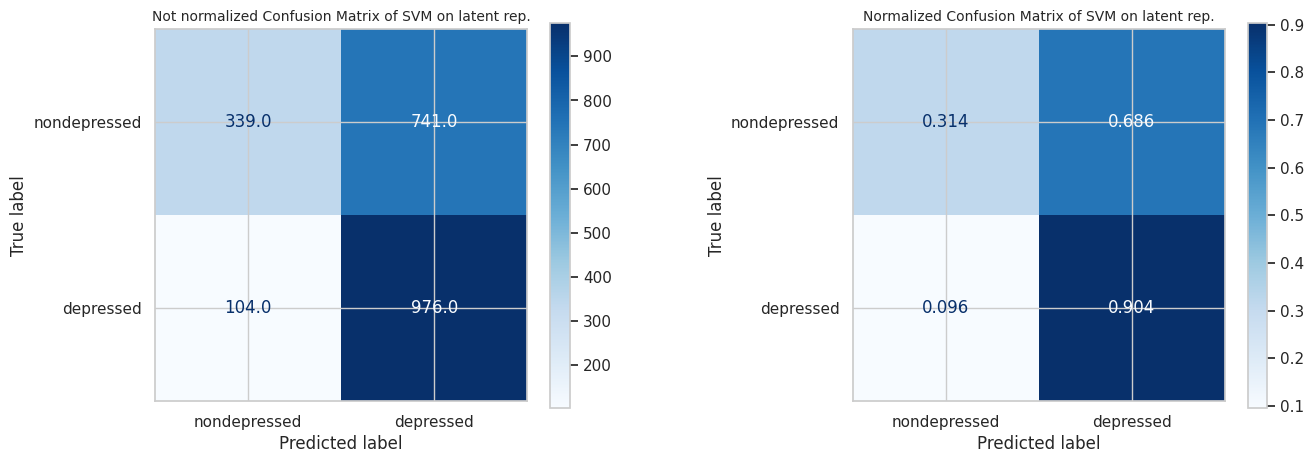

In [11]:
#testing

whole_train_x=np.concatenate((x_scaled_train, x_scaled_val), axis=0)
whole_train_y=np.concatenate([y_train, y_val])
x_nondep_train, x_dep_train = whole_train_x[whole_train_y == 0], whole_train_x[whole_train_y == 1]
#------find the new represenation of Train and Dev data as new train data
LatentRepresenation=CNNextractrep(CNN_autoencoder)

x_nondep_train = np.expand_dims(x_nondep_train, axis=2)
x_dep_train = np.expand_dims(x_dep_train, axis=2)

Nondep_hid_rep_Train =LatentRepresenation.predict(x_nondep_train)
Dep_hid_rep_Train =LatentRepresenation.predict(x_dep_train)

rep_x_Train = np.append(Nondep_hid_rep_Train, Dep_hid_rep_Train, axis = 0)#total latent representation
y_n = np.zeros(Nondep_hid_rep_Train.shape[0])
y_d = np.ones(Dep_hid_rep_Train.shape[0])
rep_y_Train = np.append(y_n, y_d)#Total labels


x_nondep_test = np.expand_dims(x_nondep_test, axis=2)
x_dep_test = np.expand_dims(x_dep_test, axis=2)
Nondep_hid_rep_Valid =LatentRepresenation.predict(x_nondep_test)
Dep_hid_rep_Valid =LatentRepresenation.predict(x_dep_test)

rep_x_Valid = np.append(Nondep_hid_rep_Valid , Dep_hid_rep_Valid, axis = 0)#total latent representation
y_n_valid = np.zeros(Nondep_hid_rep_Valid.shape[0])
y_d_valid = np.ones(Dep_hid_rep_Valid.shape[0])
rep_y_Valid = np.append(y_n_valid, y_d_valid)#Total labels

#tsne_plot(rep_x_Train, rep_y_Train, "original data with SVM")
#-------------------------------evaluate model
#  SVM classifier on trained latent space
from sklearn import svm
clf = svm.SVC(kernel='rbf')#change gamma="0.001" to scale and c if you want
clf.fit(rep_x_Train, rep_y_Train)
pred_y=clf.predict(rep_x_Valid)
print ("")
print ("Classification Report: SVM on latent")
print (classification_report(rep_y_Valid, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, pred_y))
cm = confusion_matrix(rep_y_Valid, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
print ("")
print(cm.diagonal())
#plot
fig, axes = plt.subplots(ncols=2,figsize=(15, 5))
ax1, ax2 = axes
class_names=['nondepressed','depressed']
plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax1 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.1f') 
ax1.set_title('Not normalized Confusion Matrix of SVM on latent rep.',fontsize=10)

plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax2 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.3f',normalize='true')
ax2.set_title('Normalized Confusion Matrix of SVM on latent rep.',fontsize=10) 
plt.subplots_adjust(wspace=0.50)
#plt.savefig("SVM_lat_AE.png")
#files.download("SVM_lat_AE.png")
plt.show()

In [ ]:
#还原声音信号


# checking saved model

In [26]:
CNN_autoencoder,CNN_latent=CAE_model(x_scaled_train,encodding_dim)
CNN_autoencoder.load_weights("/home/Q/Diploma_thesis/CAE_ADD-main/models/modeltotalCAE.h5")
print(CNN_autoencoder.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 4000, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2000, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2000, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2000, 128)         24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1000, 128)        0         
 1D)                                                         

66/66 [==============================] - 0s 2ms/step

Classification Report: SVM on latent
              precision    recall  f1-score   support

         0.0       0.67      0.29      0.40      2100
         1.0       0.55      0.86      0.67      2100

    accuracy                           0.57      4200
   macro avg       0.61      0.57      0.53      4200
weighted avg       0.61      0.57      0.53      4200


Accuracy Score:  0.5723809523809524

[0.28761905 0.85714286]


/home/Q/anaconda3/envs/CAE_ADD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/Q/anaconda3/envs/CAE_ADD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


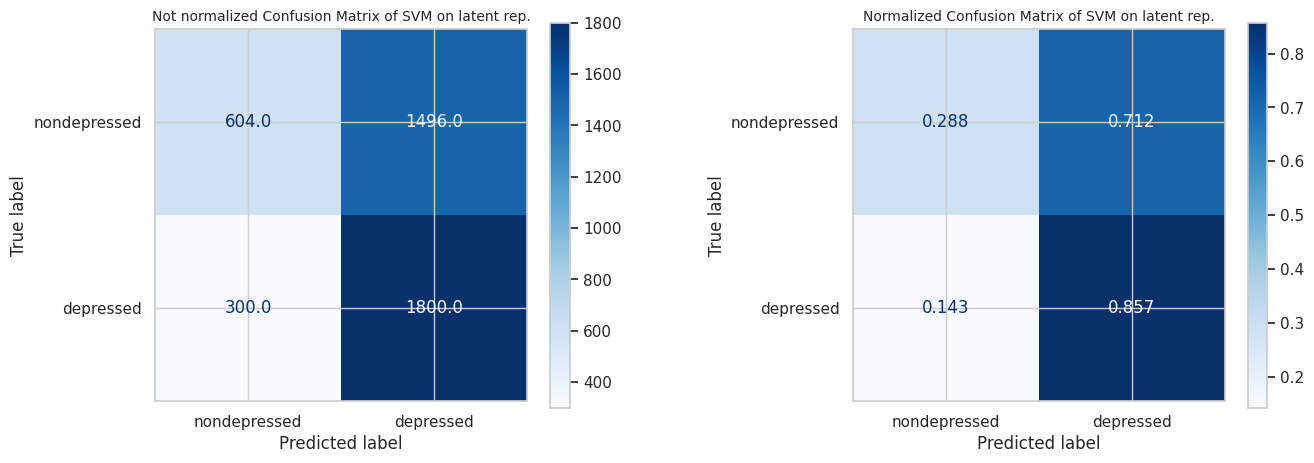

time: 2min 27s (started: 2024-01-05 11:10:44 +08:00)


In [27]:

#testing

whole_train_x=np.concatenate((x_scaled_train, x_scaled_val), axis=0)
whole_train_y=np.concatenate([y_train, y_val])
x_nondep_train, x_dep_train = whole_train_x[whole_train_y == 0], whole_train_x[whole_train_y == 1]
#------find the new represenation of Train and Dev data as new train data
LatentRepresenation=CNNextractrep(CNN_autoencoder)

x_nondep_train = np.expand_dims(x_nondep_train, axis=2)
x_dep_train = np.expand_dims(x_dep_train, axis=2)

Nondep_hid_rep_Train =LatentRepresenation.predict(x_nondep_train)
Dep_hid_rep_Train =LatentRepresenation.predict(x_dep_train)

rep_x_Train = np.append(Nondep_hid_rep_Train, Dep_hid_rep_Train, axis = 0)#total latent representation
y_n = np.zeros(Nondep_hid_rep_Train.shape[0])
y_d = np.ones(Dep_hid_rep_Train.shape[0])
rep_y_Train = np.append(y_n, y_d)#Total labels


x_nondep_test = np.expand_dims(x_nondep_test, axis=2)
x_dep_test = np.expand_dims(x_dep_test, axis=2)
Nondep_hid_rep_Valid =LatentRepresenation.predict(x_nondep_test)
Dep_hid_rep_Valid =LatentRepresenation.predict(x_dep_test)

rep_x_Valid = np.append(Nondep_hid_rep_Valid , Dep_hid_rep_Valid, axis = 0)#total latent representation
y_n_valid = np.zeros(Nondep_hid_rep_Valid.shape[0])
y_d_valid = np.ones(Dep_hid_rep_Valid.shape[0])
rep_y_Valid = np.append(y_n_valid, y_d_valid)#Total labels

#-------------------------------evaluate model
#  SVM classifier on trained latent space
from sklearn import svm
clf = svm.SVC(kernel='rbf')#change gamma="0.001" to scale and c if you want
clf.fit(rep_x_Train, rep_y_Train)
pred_y=clf.predict(rep_x_Valid)
print ("")
print ("Classification Report: SVM on latent")
print (classification_report(rep_y_Valid, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, pred_y))
cm = confusion_matrix(rep_y_Valid, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
print ("")
print(cm.diagonal())
#plot
fig, axes = plt.subplots(ncols=2,figsize=(15, 5))
ax1, ax2 = axes
class_names=['nondepressed','depressed']
plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax1 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.1f') 
ax1.set_title('Not normalized Confusion Matrix of SVM on latent rep.',fontsize=10)

plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax2 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.3f',normalize='true')
ax2.set_title('Normalized Confusion Matrix of SVM on latent rep.',fontsize=10) 
plt.subplots_adjust(wspace=0.50)
#plt.savefig("SVM_lat_AE.png")
#files.download("SVM_lat_AE.png")
plt.show()

/home/Q/anaconda3/envs/CAE_ADD/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Q/anaconda3/envs/CAE_ADD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



Classification Report: Mlp  on latent
              precision    recall  f1-score   support

         0.0       0.77      0.52      0.62      2100
         1.0       0.64      0.85      0.73      2100

    accuracy                           0.68      4200
   macro avg       0.70      0.68      0.67      4200
weighted avg       0.70      0.68      0.67      4200


Accuracy Score:  0.6821428571428572

[0.51666667 0.84761905]


/home/Q/anaconda3/envs/CAE_ADD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


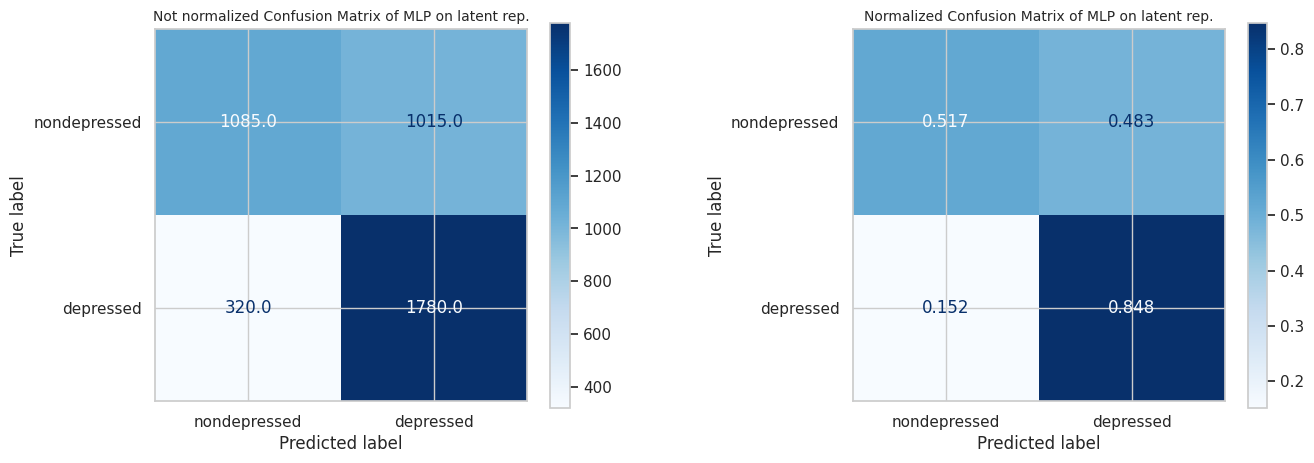

time: 35.1 s (started: 2024-01-05 11:13:12 +08:00)


In [28]:

#-------------------------------evaluate model
#  MLP classifier on trained latent space
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1,hidden_layer_sizes=(128,100,),activation='logistic', max_iter=100).fit(rep_x_Train, rep_y_Train)
pred_y=clf.predict(rep_x_Valid)
print ("")
print ("Classification Report: Mlp  on latent")
print (classification_report(rep_y_Valid, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, pred_y))
cm = confusion_matrix(rep_y_Valid, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
print ("")
print(cm.diagonal())
#plot
fig, axes = plt.subplots(ncols=2,figsize=(15, 5))
ax1, ax2 = axes
class_names=['nondepressed','depressed']
plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax1 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.1f') 
ax1.set_title('Not normalized Confusion Matrix of MLP on latent rep.',fontsize=10)

plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax2 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.3f',normalize='true')
ax2.set_title('Normalized Confusion Matrix of MLP on latent rep.',fontsize=10) 
plt.subplots_adjust(wspace=0.50)
plt.show()